In [1]:
# this is basically building and adversarial attack on vision model like resnet 50
from torch import nn
from torch_snippets import show , np , torch
from torchvision.models import resnet50 , ResNet50_Weights
from torchinfo import summary
import requests
from PIL import Image
from torchvision import transforms as T
from torch.nn import functional as F

In [2]:
# Download the ResNet50 model pretrained weights
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Turn off parameter updates for the model
for param in model.parameters():
    param.requires_grad = False


In [3]:
summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            (9,408)
├─BatchNorm2d: 1-2                       (128)
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  (4,096)
│    │    └─BatchNorm2d: 3-2             (128)
│    │    └─Conv2d: 3-3                  (36,864)
│    │    └─BatchNorm2d: 3-4             (128)
│    │    └─Conv2d: 3-5                  (16,384)
│    │    └─BatchNorm2d: 3-6             (512)
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              (16,896)
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  (16,384)
│    │    └─BatchNorm2d: 3-10            (128)
│    │    └─Conv2d: 3-11                 (36,864)
│    │    └─BatchNorm2d: 3-12            (128)
│    │    └─C

# lets look at the default classes this model was trained on :
pytorch resnet doc : https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html

* we can see it was trained on the imagenet 1k dataset

In [4]:
# lets get teh dataset and show the classes
img_net_1k = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt'
img_net_1k = requests.get(img_net_1k).text
img_net_1k_ids = eval(img_net_1k) # gives you a dictionary containing all classes -> 0:{horse}
img_net_1k_classes = {i:j for (j,i) in img_net_1k_ids.items()} # so we can acces the index through the class directly ex. below
img_net_1k_classes['strawberry'] # example class

949

In [5]:
# Let's now grab an image that we will use in our adversarial attack from the web

url = 'https://clv.h-cdn.co/assets/15/22/2560x1280/landscape-1432664914-strawberry-facts1.jpg'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    with open('./images/img_2.jpg', 'wb') as file:
        file.write(response.content)
    print("Image downloaded successfully.")
else:
    print(f"Failed to download image. Status code: {response.status_code}")


Image downloaded successfully.


### Resize function incase we want to resize the image

In [6]:
def resize_and_save_jpeg(input_path, output_path, height, width):
    """
    Resize a JPEG image and save the resized image with the same file extension.

    Args:
    - input_path (str): Path to the input JPEG image.
    - output_path (str): Path to save the resized image.
    - height (int): Desired height for the resized image.
    - width (int): Desired width for the resized image.
    """

    # Open the input JPEG image
    original_img = Image.open(input_path)

    # Resize the image
    resized_img = original_img.resize((width, height))

    # Save the resized image with the same file extension
    resized_img.save(output_path, format=original_img.format)

In [7]:
# Example usage:
input_jpeg_path = './images/img_2.jpg'  # Replace with the actual path
output_jpeg_path = './images/img_2.jpg'  # Replace with the desired output path
resize_and_save_jpeg(input_jpeg_path, output_jpeg_path, height=515, width=512)

In [8]:
img = Image.open('./images/img_2.jpg').convert('RGB')
img_np = np.array(img)
img_tensor = torch.tensor(img_np)

In [9]:
img_tensor.shape

torch.Size([515, 512, 3])

In [10]:
# Define normalization and denormalization transformations
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
denormalize = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                        std=[1/0.229, 1/0.224, 1/0.225])

"""The values [0.485, 0.456, 0.406] and [0.229, 0.224, 0.225]
    used in the normalize transformation are mean and standard deviation
    values that come from the ImageNet dataset. These values are commonly
    used for pre-trained models, especially those trained on ImageNet,
    to normalize input images during training and inference.

    These specific values were calculated from the mean and standard deviation
    of the ImageNet dataset, which is a large dataset commonly used for
    training and evaluating computer vision models. 
    The mean values represent the average values of the RGB channels across all images in the dataset,
    and the standard deviation values represent the spread or variability of the pixel values."""

# Function to convert an image to a normalized PyTorch tensor
def image_to_tensor(img):
    # Clone the input, permute dimensions, and apply normalization
    img_np = np.array(img)
    img_tensor = torch.tensor(img_np).permute(2, 0, 1)
    normalized_img = normalize( img_tensor / 255.)
    return normalized_img

# Function to convert PyTorch tensor to an image
def tensor_to_image(input_tensor):
    input_tensor = denormalize(input_tensor).permute(1,2,0)
    input_tensor = input_tensor * 255 # getting the real values
    input_tensor = input_tensor.to(torch.uint8)
    return input_tensor

In [11]:
# lets run some expriments on this
f = image_to_tensor(img)
c = tensor_to_image(f)

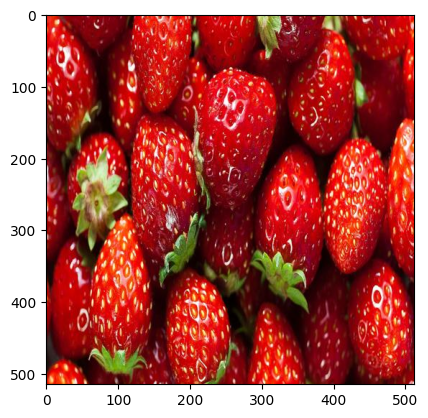

In [12]:
import matplotlib.pyplot as plt
c
plt.imshow(c)

In [13]:
def predict_on_image(input):
    model.eval()
    show(input)
    input = image_to_tensor(input).unsqueeze(dim=0)
    pred = model(input)
    pred = F.softmax(pred, dim=-1)[0]
    prob, clss = torch.max(pred, 0)
    # print(clss)
    # print(prob)
    clss = img_net_1k_ids[int(clss)]
    print(f'PREDICTION: `{clss}` P : {prob.item()}')

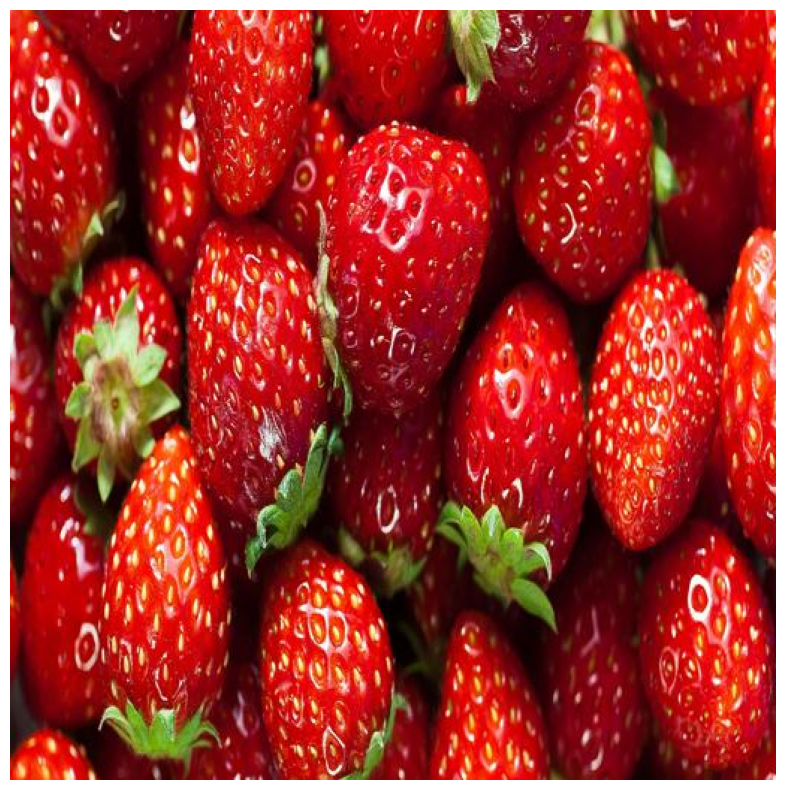

PREDICTION: `strawberry` P : 0.9950403571128845


In [14]:
predict_on_image(img)

In [15]:
# lets write down the attacker function
losses = []
def Attacker(image,model,target,epislon=1e-6):
    input = image_to_tensor(image).unsqueeze(dim=0)
    # print(f'this is shape before into model {input.shape}')
    input.requires_grad = True
    
    pred = model(input)

    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(pred, target)

    loss.backward()

    losses.append(loss.mean().item())

    output = input - epislon * input.grad.sign()
    """In the preceding code, we are updating input values by a very small
        amount (multiplying by epsilon). Also, we are not updating the image
        by the magnitude of the gradient, but the direction of gradient only
        (input.grad.sign()) after multiplying it by a very small value (epsilon)."""
    
    output = tensor_to_image(output.squeeze(dim=0))
    return output.detach() # lets detach it from cimputation graph

In [16]:
modified_images = []
desired_targets = ['lemon', 'comic book', 'sax, saxophone']

In [17]:
from tqdm import trange
for target in desired_targets:
    target = torch.tensor([img_net_1k_classes[target]]) # this will print index associated with desired target
    image_to_attack = img
    for _ in trange(10):
        image_to_attack = Attacker(image_to_attack, model, target)
    modified_images.append(image_to_attack)

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


In [18]:
modified_images[1].shape

torch.Size([515, 512, 3])

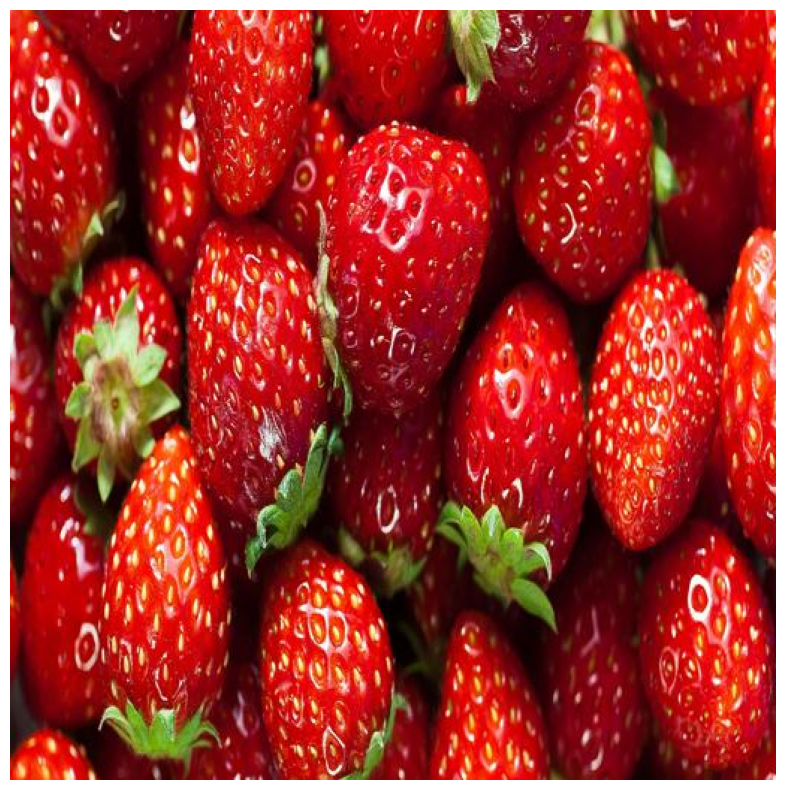

PREDICTION: `strawberry` P : 0.9950403571128845


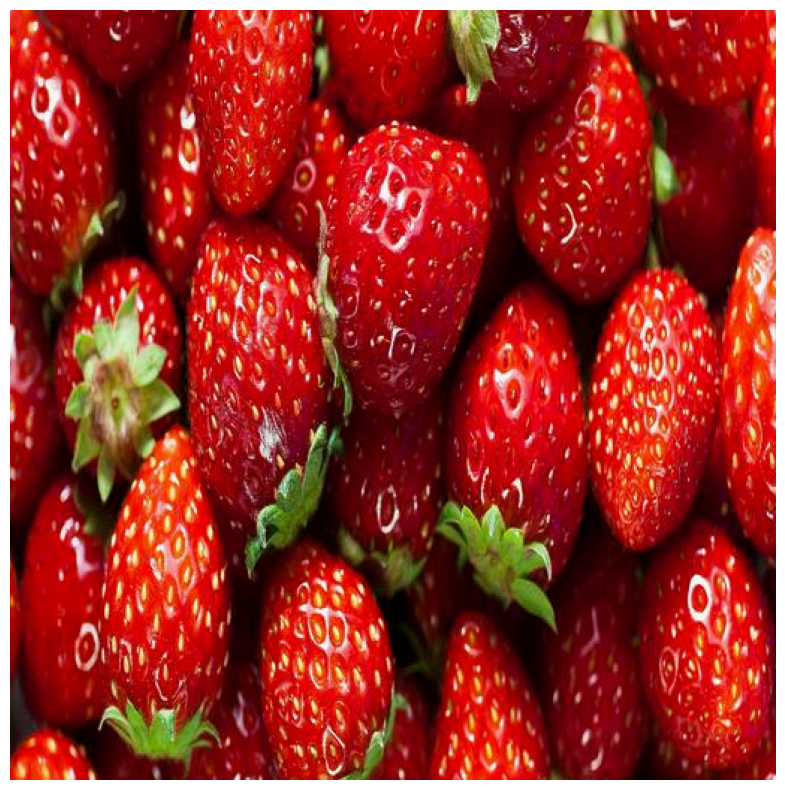

PREDICTION: `lemon` P : 0.9645379781723022


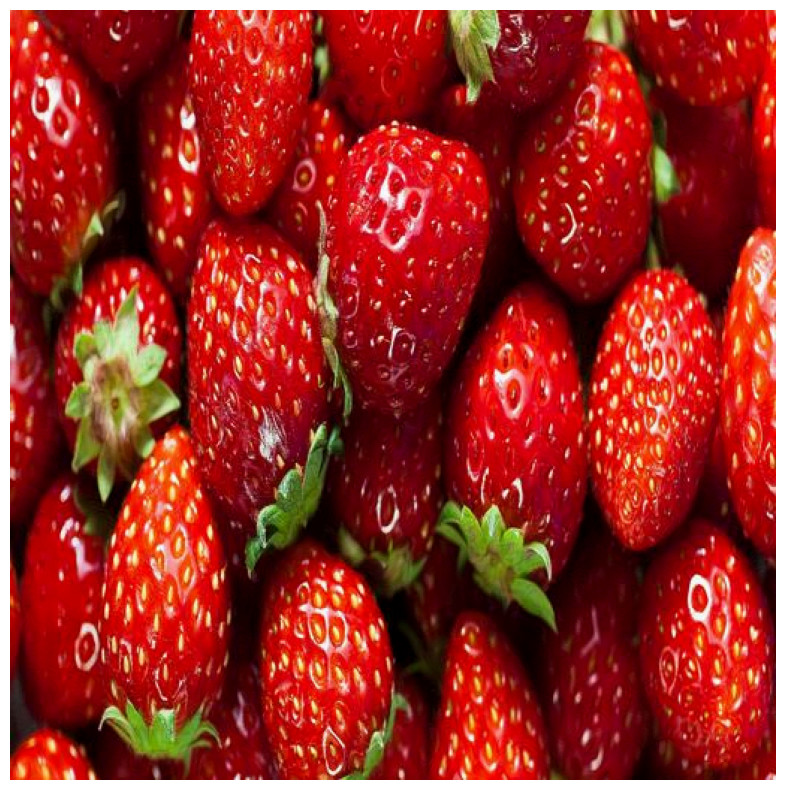

PREDICTION: `comic book` P : 0.9966902732849121


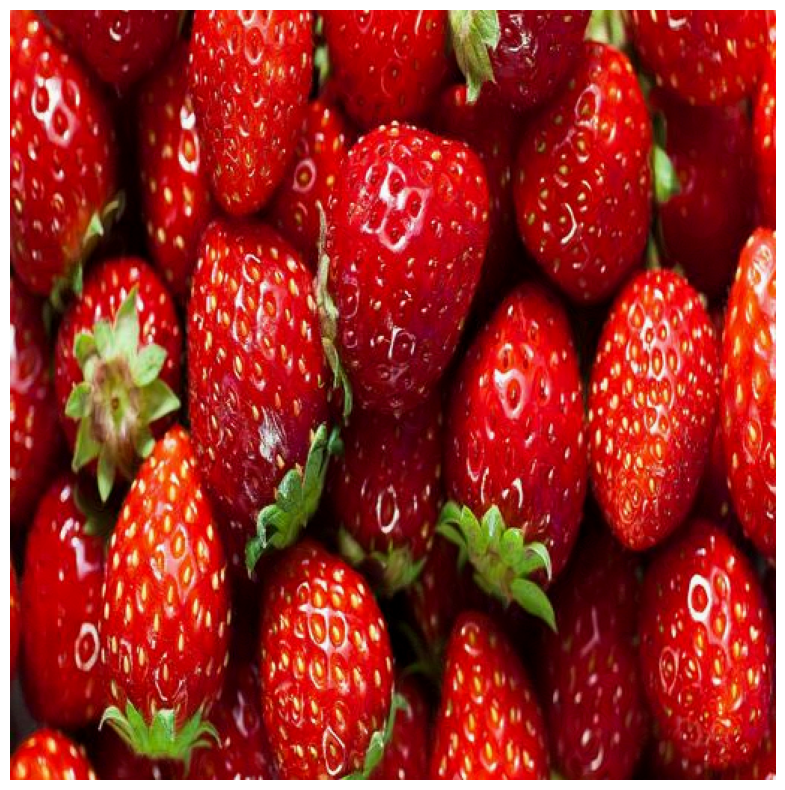

PREDICTION: `sax, saxophone` P : 0.9344428181648254


In [19]:
for image in [img, *modified_images]:
    predict_on_image(image)